# Capstone Project- DeepImageDroid

In [1]:
## Import initial Liberies
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#access grey scale image from storage
path_root = "C:/Users/chime/Capstone project/Dataset/grey_scaled_images"

## Preprocessing images for our models 

In [3]:
# preprocess image with image data generator

from keras.preprocessing.image import ImageDataGenerator

batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=45000)



Found 44262 images belonging to 2 classes.


In [4]:
# adding label to the grey scale images based on their class folders

imgs, labels = next(batches)

In [5]:
imgs.shape

(44262, 64, 64, 3)

In [6]:
# plot images and show the lables according to the classes they belong (malware & benign)

def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

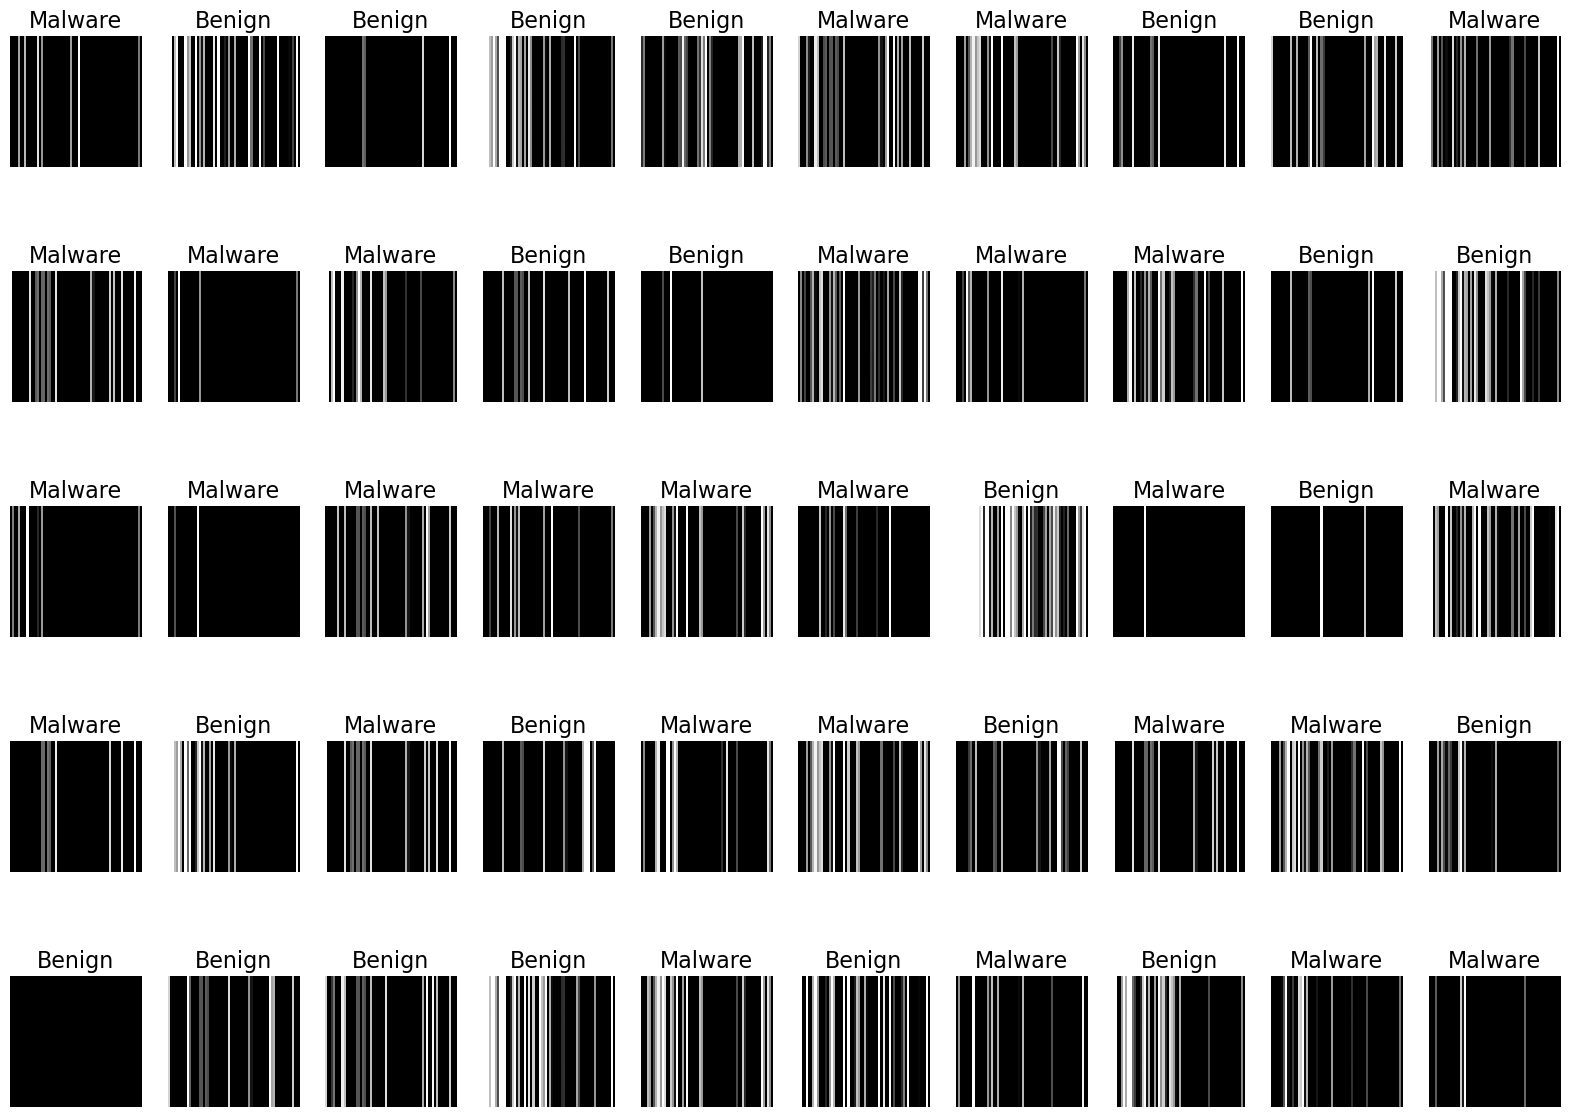

In [7]:
plots(imgs, titles = labels)

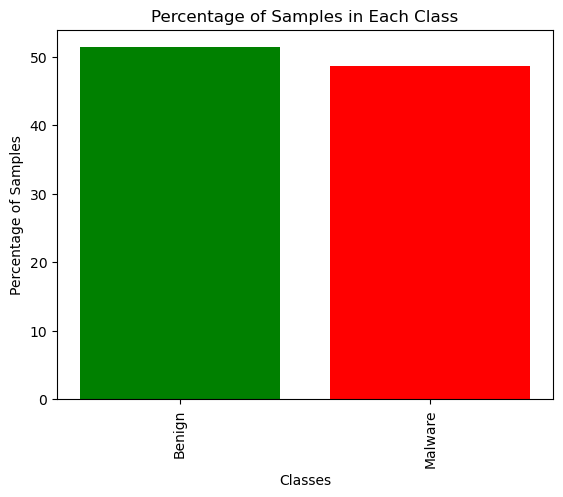

In [8]:
# Class distribution of the grey scaled image dataset

import matplotlib.pyplot as plt
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

# Define colors for each class
colors = ['green', 'red']  # Example colors for two classes

# Plot the bar chart with different colors for each class
plt.bar(classes, perc, color=colors)

# Customize the plot
plt.xticks(rotation='vertical')
plt.xlabel('Classes')
plt.ylabel('Percentage of Samples')
plt.title('Percentage of Samples in Each Class')

# Show the plot
plt.show()

## Spliting the dataset for our experiment

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [51]:
X_train.shape

(30983, 64, 64, 3)

In [52]:
X_test.shape

(13279, 64, 64, 3)

In [53]:
y_train.shape

(30983, 2)

In [54]:
y_test.shape

(13279, 2)

## Visual Transformers (ViTs) Model

In [55]:
# import neccesary libs

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa
import tensorflow as tf


# Creating ViTs model for DeepImageDroid with parameter and hyperparameter tunning

In [56]:
num_classes = labels.shape[1]
input_shape = imgs.shape[1:]

learning_rate = 0.0005
weight_decay = 0.0001
batch_size = 64
num_epochs = 20
patience = 15 # After patience epoch stop if not improve
image_size = 64  
patch_size = 11  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
# Here input_shape=(66,66),patch shape=(11,11) -> 36 patches
projection_dim = 36
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [57]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,
        })
        return config

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
        })
        return config

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [58]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
        ],
    )
    
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0) # when patience epoch val_loss not improve, stop train
    
    callbacks = [es]

    history = model.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(X_test, y_test),
          callbacks=callbacks,
    )

    return history

vit_classifier = create_vit_classifier()


In [59]:
# summary of the ViTs Model
vit_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 patches_1 (Patches)         (None, None, 363)            0         ['input_2[0][0]']             
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 25, 36)               14004     ['patches_1[0][0]']           
 der)                                                                                             
                                                                                                  
 layer_normalization_17 (La  (None, 25, 36)               72        ['patch_encoder_1[0][0]'

In [60]:
# train model
history = run_experiment(vit_classifier)

Epoch 1/20
485/485 [==============================] - 228s 448ms/step - loss: 0.2341 - accuracy: 0.9065 - auc: 0.9247 - val_loss: 0.1643 - val_accuracy: 0.9339 - val_auc: 0.9441
Epoch 2/20
485/485 [==============================] - 206s 425ms/step - loss: 0.1715 - accuracy: 0.9298 - auc: 0.9468 - val_loss: 0.1529 - val_accuracy: 0.9375 - val_auc: 0.9532
Epoch 3/20
485/485 [==============================] - 208s 430ms/step - loss: 0.1567 - accuracy: 0.9365 - auc: 0.9528 - val_loss: 0.1460 - val_accuracy: 0.9430 - val_auc: 0.9537
Epoch 4/20
485/485 [==============================] - 204s 421ms/step - loss: 0.1437 - accuracy: 0.9415 - auc: 0.9561 - val_loss: 0.1404 - val_accuracy: 0.9445 - val_auc: 0.9576
Epoch 5/20
485/485 [==============================] - 211s 435ms/step - loss: 0.1365 - accuracy: 0.9446 - auc: 0.9592 - val_loss: 0.1337 - val_accuracy: 0.9461 - val_auc: 0.9585
Epoch 6/20
485/485 [==============================] - 182s 376ms/step - loss: 0.1306 - accuracy: 0.9476 - auc:

# Visualize model's Performance/ Visualize the model's training evaluation metrics

Available Metrics: ['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc']


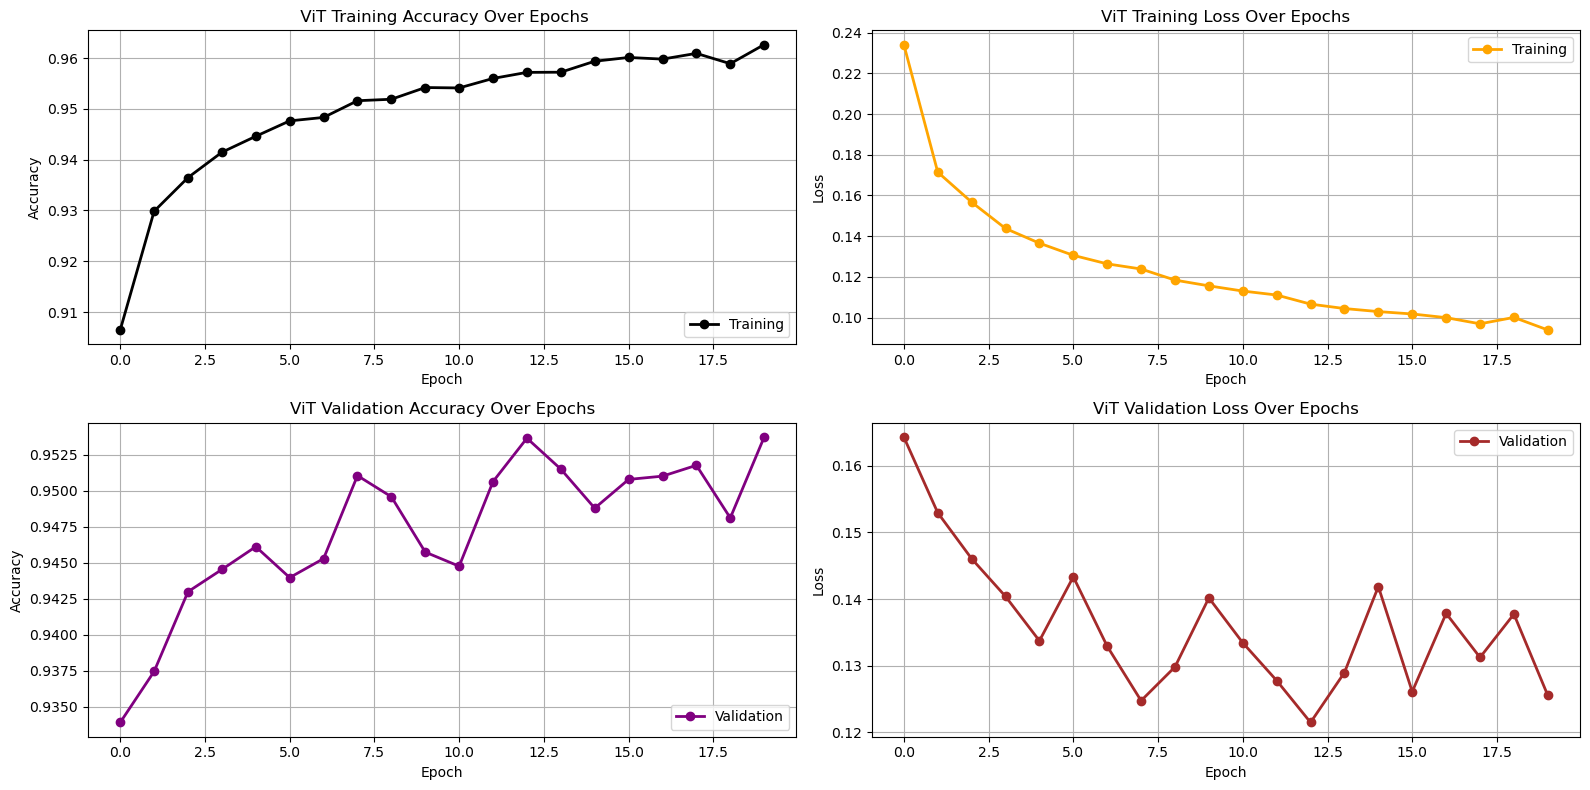

In [162]:
# Print available metrics
print("Available Metrics:", list(history.history.keys()))

# Create a colorful and dynamic visualization
plt.figure(figsize=(16, 8))

# Plot training accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], color='black', marker='o', linestyle='-', linewidth=2)
plt.title(' ViT Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Training'], loc='lower right')

# Plot training loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], color='orange', marker='o', linestyle='-', linewidth=2)
plt.title('ViT Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['Training'], loc='upper right')

# Plot validation accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['val_accuracy'], color='purple', marker='o', linestyle='-', linewidth=2)
plt.title('ViT Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Validation'], loc='lower right')

# Plot validation loss
plt.subplot(2, 2, 4)
plt.plot(history.history['val_loss'], color='brown', marker='o', linestyle='-', linewidth=2)
plt.title('ViT Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['Validation'], loc='upper right')

plt.tight_layout()
plt.show()

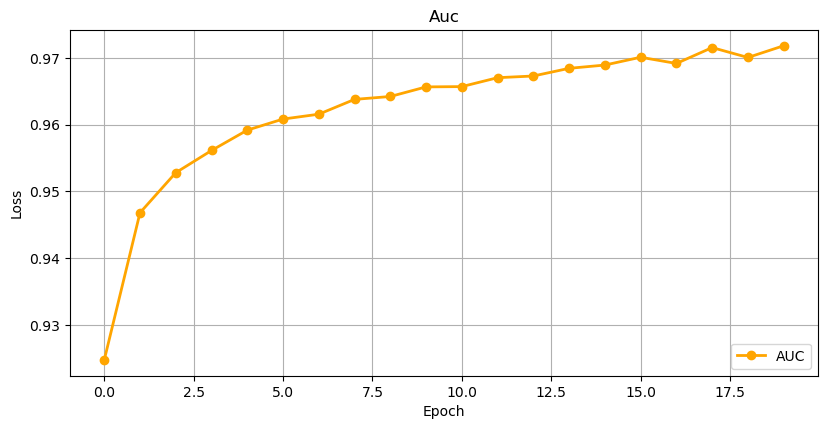

In [163]:
# Create a colorful and dynamic visualization
plt.figure(figsize=(16, 8))

# Plot validation AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], color='orange', marker='o', linestyle='-', linewidth=2)
plt.title('Auc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['AUC'], loc='lower right')

plt.tight_layout()
plt.show()

# Test/Evaluate the Model

In [164]:
# Evaluate the model on test data

scores = vit_classifier.evaluate(X_test, y_test)

415/415 [==============================] - 31s 71ms/step - loss: 0.1255 - accuracy: 0.9537 - auc: 0.9635


In [165]:
# Print the final accuracy of the model on the test data

print('Final ViT accuracy: ', scores[1])

Final ViT accuracy:  0.9537239074707031


In [166]:
# test the model's prediction on the heldout test set

y_pred_prob = vit_classifier.predict(X_test, verbose=0)
y_pred = np.argmax(np.array(y_pred_prob),axis = 1)

In [167]:
y_pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [168]:
y_test2 = np.argmax(y_test, axis=1)

In [169]:
y_test2

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

Confusion Metrics of the ViTs Model

In [170]:
from sklearn import metrics
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt  

In [171]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)


def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

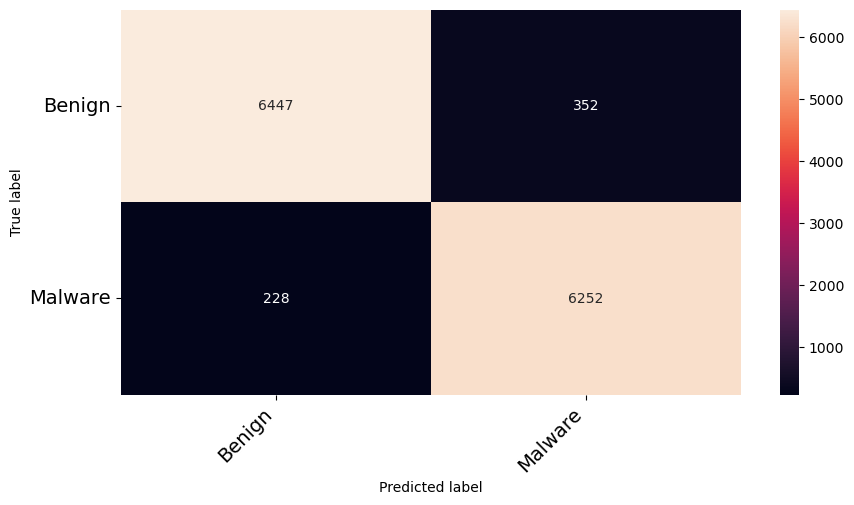

In [172]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (10,5), fontsize=14)

In [173]:
# Extract values from confusion matrix
TN, FP, FN, TP = c_matrix.ravel()

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)

# Compute False Negative Rate (FNR)
FNR = FN / (FN + TP)

print("False Negative Rate (FNR):", FNR)

False Positive Rate (FPR): 0.051772319458743936
True Positive Rate (TPR): 0.9648148148148148
False Negative Rate (FNR): 0.03518518518518519


In [174]:
# generate classification report

from sklearn.metrics import classification_report

report = metrics.classification_report(y_test2, y_pred, target_names=classes,  output_dict=True)

report_df = pd.DataFrame(report)
report_df = report_df.transpose()

print(report_df)

              precision    recall  f1-score       support
Benign         0.965843  0.948228  0.956954   6799.000000
Malware        0.946699  0.964815  0.955671   6480.000000
accuracy       0.956322  0.956322  0.956322      0.956322
macro avg      0.956271  0.956521  0.956313  13279.000000
weighted avg   0.956501  0.956322  0.956328  13279.000000


In [74]:
vit_classifier.save ('saved models/vit_classifier')

INFO:tensorflow:Assets written to: saved models/vit_classifier\assets


INFO:tensorflow:Assets written to: saved models/vit_classifier\assets


# Creating CNN Model for DeepImageDroid with parameter and hyperparameter tunning

In [75]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [79]:
num_classes = 2

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    Malware_model.add(Conv2D(64, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    
    
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='sigmoid'))
    Malware_model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

Malware_model = malware_model()

In [80]:
#Summary of the model
Malware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 12544)            

In [81]:
#train Model
history2 = Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20) 

Epoch 1/20
969/969 [==============================] - 119s 122ms/step - loss: 0.2237 - accuracy: 0.9112 - val_loss: 0.1775 - val_accuracy: 0.9281
Epoch 2/20
969/969 [==============================] - 117s 121ms/step - loss: 0.1713 - accuracy: 0.9337 - val_loss: 0.1483 - val_accuracy: 0.9397
Epoch 3/20
969/969 [==============================] - 117s 121ms/step - loss: 0.1505 - accuracy: 0.9417 - val_loss: 0.1402 - val_accuracy: 0.9450
Epoch 4/20
969/969 [==============================] - 115s 119ms/step - loss: 0.1395 - accuracy: 0.9452 - val_loss: 0.1326 - val_accuracy: 0.9465
Epoch 5/20
969/969 [==============================] - 112s 115ms/step - loss: 0.1303 - accuracy: 0.9497 - val_loss: 0.1289 - val_accuracy: 0.9502
Epoch 6/20
969/969 [==============================] - 112s 116ms/step - loss: 0.1252 - accuracy: 0.9528 - val_loss: 0.1264 - val_accuracy: 0.9482
Epoch 7/20
969/969 [==============================] - 120s 124ms/step - loss: 0.1194 - accuracy: 0.9538 - val_loss: 0.1209 -

# Visualize the model's training evaluation metrics

Available Metrics: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


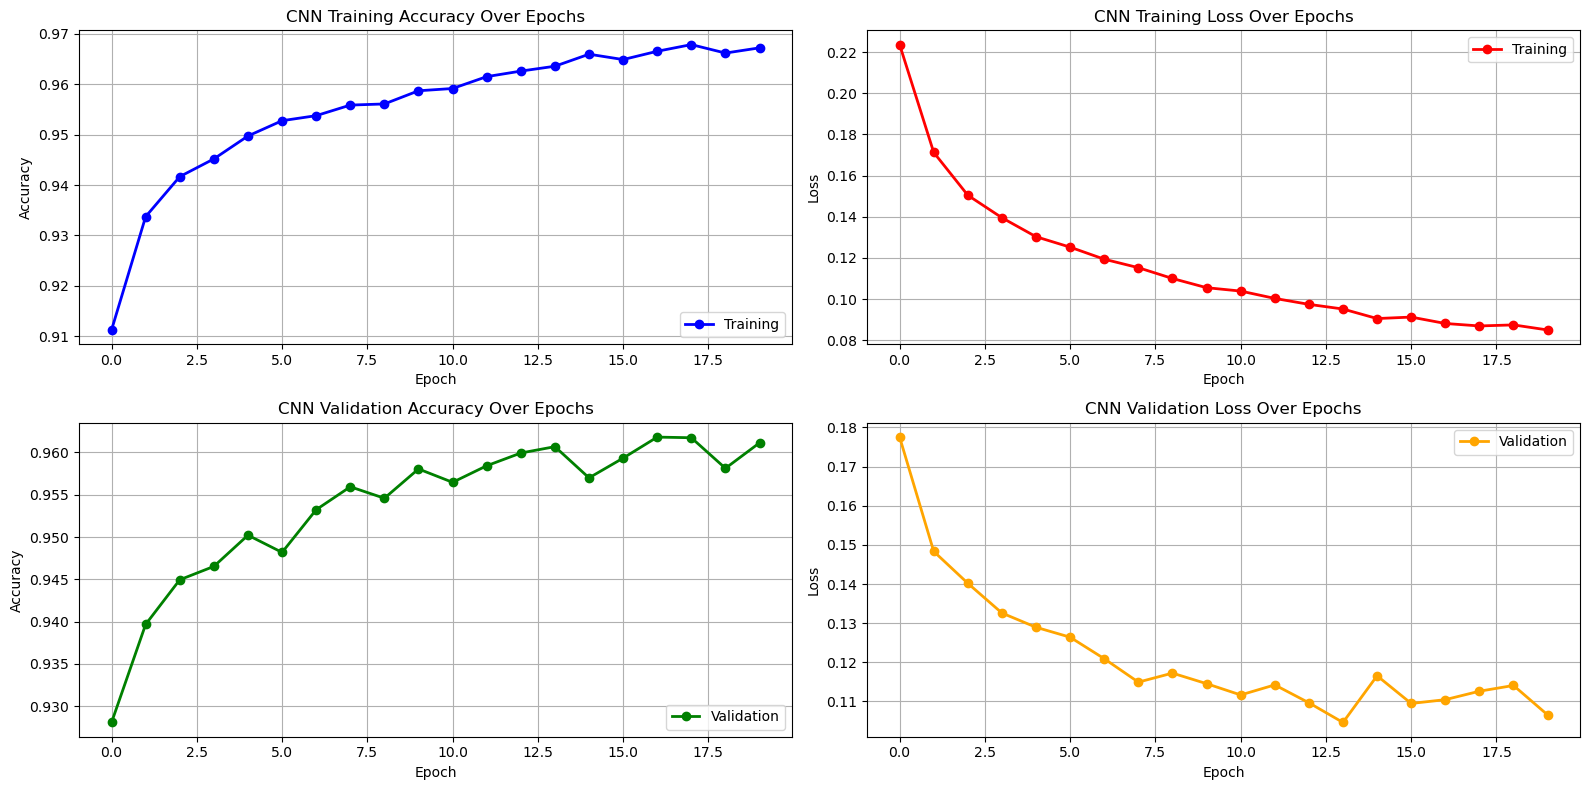

In [82]:
# Print available metrics
print("Available Metrics:", list(history2.history.keys()))

# Create a colorful and dynamic visualization
plt.figure(figsize=(16, 8))

# Plot training accuracy
plt.subplot(2, 2, 1)
plt.plot(history2.history['accuracy'], color='blue', marker='o', linestyle='-', linewidth=2)
plt.title('CNN Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Training'], loc='lower right')

# Plot training loss
plt.subplot(2, 2, 2)
plt.plot(history2.history['loss'], color='red', marker='o', linestyle='-', linewidth=2)
plt.title('CNN Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['Training'], loc='upper right')

# Plot validation accuracy
plt.subplot(2, 2, 3)
plt.plot(history2.history['val_accuracy'], color='green', marker='o', linestyle='-', linewidth=2)
plt.title('CNN Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(['Validation'], loc='lower right')

# Plot validation loss
plt.subplot(2, 2, 4)
plt.plot(history2.history['val_loss'], color='orange', marker='o', linestyle='-', linewidth=2)
plt.title('CNN Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(['Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Test/Evaluate the Model

In [83]:
# evaluate the model on test data 
scores2 = Malware_model.evaluate(X_test, y_test)

415/415 [==============================] - 12s 29ms/step - loss: 0.1066 - accuracy: 0.9611


In [84]:
# Print the final accuracy of the model on the test data
print('Final CNN accuracy: ', scores2[1])

Final CNN accuracy:  0.9611416459083557


In [85]:
# test the model's prediction on the heldout test set

y_pred_prob = Malware_model.predict(X_test, verbose=0)
y_pred2 = np.argmax(np.array(y_pred_prob),axis = 1)

In [86]:
y_pred2

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [87]:
y_test_cnn = np.argmax(y_test, axis=1)

In [88]:
y_test_cnn

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

Confusion Metrics of the CNN Model

In [89]:
c_matrix_cnn = metrics.confusion_matrix(y_test_cnn, y_pred2)


def confusion_matrix(confusion_matrix, class_names_2, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_2, columns=class_names_2, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

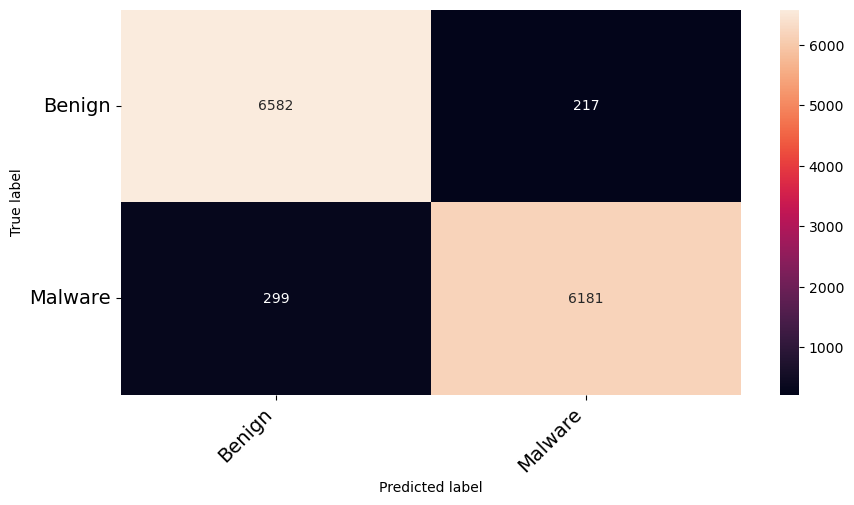

In [90]:
class_names_2= batches.class_indices.keys()
confusion_matrix(c_matrix_cnn, class_names_2, figsize = (10,5), fontsize=14)

In [91]:
# Extract values from confusion matrix
TN, FP, FN, TP = c_matrix_cnn.ravel()

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)

# Compute False Negative Rate (FNR)
FNR = FN / (FN + TP)

print("False Negative Rate (FNR):", FNR)

False Positive Rate (FPR): 0.031916458302691575
True Positive Rate (TPR): 0.953858024691358
False Negative Rate (FNR): 0.046141975308641975


In [92]:
# generate classification report

report_cnn = metrics.classification_report(y_test_cnn, y_pred2, target_names=classes,  output_dict=True)

report_df_cnn = pd.DataFrame(report_cnn)
report_df_cnn = report_df_cnn.transpose()

print(report_df_cnn)

              precision    recall  f1-score       support
Benign         0.956547  0.968084  0.962281   6799.000000
Malware        0.966083  0.953858  0.959932   6480.000000
accuracy       0.961142  0.961142  0.961142      0.961142
macro avg      0.961315  0.960971  0.961106  13279.000000
weighted avg   0.961201  0.961142  0.961134  13279.000000


In [93]:
Malware_model.save ('saved models/Malware_model')

INFO:tensorflow:Assets written to: saved models/Malware_model\assets


INFO:tensorflow:Assets written to: saved models/Malware_model\assets


# Create DeepImageDroid, the Hybrid ensemble model using average weighted method

In [94]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

In [95]:
# load ViTs and CNN model, combine both to make prediction on unseen data

# Load the CNN model
Malware_model = load_model('saved models/Malware_model')

# Load the ViT (Vision Transformer) model
vit_classifier = load_model('saved models/vit_classifier')

# Combine the models into a list
models = [Malware_model,vit_classifier]

# Make predictions on unseen data with each model in the list
preds = [model.predict (X_test) for model in models]


# Take the average of the predictions across all models
average_pred = np.mean(preds, axis=0)

# create ensemble prediction based on average predictions- DeepImageDroid
ensemble_prediction = (average_pred > 0.5).astype(int)

415/415 [==============================] - 34s 79ms/step


In [147]:
# Define weights for each model (adjustyed based on the best performing model)
weights = [0.9, 0.5]  

# Calculate weighted average of the predicted probabilities
weighted_pred = np.tensordot(preds, weights, axes=((0), (0)))

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
Weighted_ensemble_prediction = (weighted_pred > 0.5).astype(int)


In [148]:
weighted_accuracy = accuracy_score (y_test, Weighted_ensemble_prediction)

print("accuracy score for weighted average Ensemble :", weighted_accuracy)

accuracy score for weighted average Ensemble : 0.9580540703366217


In [149]:
#confusion Matrix and classification report

from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix for the hybrid model
conf_matrix = confusion_matrix(y_test.argmax(axis=1), Weighted_ensemble_prediction.argmax(axis=1))

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
classification_report = classification_report(y_test.argmax(axis=1), Weighted_ensemble_prediction.argmax(axis=1))
print("\nClassification Report:")
print(classification_report)

Confusion Matrix:
[[6509  290]
 [ 241 6239]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6799
           1       0.96      0.96      0.96      6480

    accuracy                           0.96     13279
   macro avg       0.96      0.96      0.96     13279
weighted avg       0.96      0.96      0.96     13279



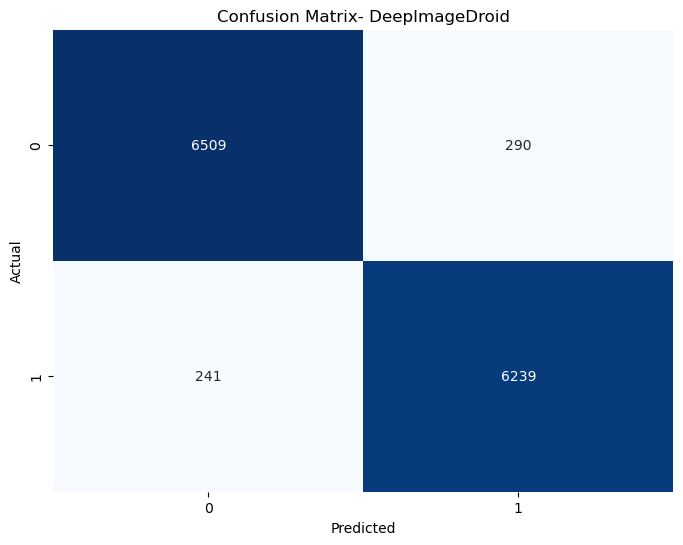

In [175]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix- DeepImageDroid')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [151]:
# Extract values from confusion matrix
TN, FP, FN, TP =conf_matrix.ravel()

# Compute False Positive Rate (FPR) and True Positive Rate (TPR)
FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)

# Compute False Negative Rate (FNR)
FNR = FN / (FN + TP)

print("False Negative Rate (FNR):", FNR)

False Positive Rate (FPR): 0.04265333137226063
True Positive Rate (TPR): 0.9628086419753087
False Negative Rate (FNR): 0.03719135802469136
